## NYC COVID-19 Cases & Population Health Status

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
import geoplot

In [2]:
#Population based on 2010 population census

nyc_population =  pd.read_csv("data/uhf_population2010.csv")

nyc_population = nyc_population[['United Hospital Fund (UHF 42) neighborhood, 2009', 'Borough', 'Total population, 2010']]

nyc_population.rename(columns = {'United Hospital Fund (UHF 42) neighborhood, 2009': 'neighborhood',
                                'Borough': 'borough',
                                'Total population, 2010': 'population'}, inplace = True)
nyc_population.head()

,neighborhood,borough,population
0,Kingsbridge - Riverdale,Bronx,94095
1,Northeast Bronx,Bronx,190315
2,Fordham - Bronx Pk,Bronx,250249
3,Pelham - Throgs Neck,Bronx,297059
4,Crotona-Tremont,Bronx,206630


In [3]:
test_by_zip = pd.read_csv("data/tests-by-zcta.csv", dtype= {'MODZCTA': str} )

test_by_zip = test_by_zip[1:]
test_by_zip.reset_index(drop = True, inplace = True)

test_by_zip.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos
0,10001,321,1130,28.41
1,10002,931,2457,37.89
2,10003,414,1549,26.73
3,10004,28,108,25.93
4,10005,54,256,21.09


In [4]:
uhf42_zipcodes = pd.read_csv("data/uhf42_zipcodes.csv")

uhf42_zipcodes['uhf42_neigh'] = uhf42_zipcodes['Neighborhood'].str.strip()

uhf42_zipcodes.head()

,Borough,Neighborhood,ZIP Codes,uhf42_neigh
0,Bronx,Fordham - Bronx Pk,"10458, 10467, 10468",Fordham - Bronx Pk
1,Bronx,Kingsbridge - Riverdale,"10463, 10471",Kingsbridge - Riverdale
2,Bronx,Northeast Bronx,"10466, 10469, 10470, 10475",Northeast Bronx
3,Bronx,Pelham - Throgs Neck,"10461, 10462, 10464, 10465, 10472, 10473",Pelham - Throgs Neck
4,Bronx,Hunts Point - Mott Haven,"10454, 10455, 10459, 10474",Hunts Point - Mott Haven


In [5]:
uhf34_zipcodes = pd.read_csv("data/uhf34_zipcodes.csv")

uhf34_zipcodes['uhf34_neigh'] = uhf34_zipcodes['Neighborhood'].str.strip()

uhf34_zipcodes.head()

,Borough,Neighborhood,ZIP Codes,uhf34_neigh
0,Bronx,Fordham - Bronx Pk,"10458, 10467, 10468",Fordham - Bronx Pk
1,NaN,Kingsbridge - Riverdale,"10463, 10471",Kingsbridge - Riverdale
2,NaN,Northeast Bronx,"10466, 10469, 10470, 10475",Northeast Bronx
3,NaN,Pelham - Throgs Neck,"10461, 10462, 10464, 10465, 10472, 10473",Pelham - Throgs Neck
4,NaN,South Bronx,"10451, 10452, 10453, 10454, 10455, 10456, 1045...",South Bronx


In [6]:
# MODZCTA_neighborhood = pd.concat([pd.Series(row['Neighborhood'], row['ZIP Codes'].split(',')) for _, row in uhf34_zipcodes.iterrows()]).reset_index()

# MODZCTA_neighborhood.rename(columns = {'index': 'zipcode', 0: 'neighborhood'}, inplace = True)

# MODZCTA_neighborhood.head()

In [7]:
#Mapping zipcodes to their  neighborhood

def uhf34zip_mapping(zipcode):
    neigh = uhf34_zipcodes['Neighborhood'][uhf34_zipcodes["ZIP Codes"].str.contains(zipcode)]
    return neigh.values
    
def uhf42zip_mapping(zipcode):
    neigh = uhf42_zipcodes['Neighborhood'][uhf42_zipcodes["ZIP Codes"].str.contains(zipcode)]
    return neigh.values
        
test_by_zip['MODZCTA'] = test_by_zip['MODZCTA'].str.strip()

test_by_zip['uhf34_neigh'] = test_by_zip['MODZCTA'].apply(uhf34zip_mapping)
test_by_zip['uhf42_neigh'] = test_by_zip['MODZCTA'].apply(uhf42zip_mapping)


test_by_zip['uhf34_neigh'] = test_by_zip['uhf34_neigh'].apply(lambda x: str(x).replace("['","").replace("']",""))
test_by_zip['uhf42_neigh'] = test_by_zip['uhf42_neigh'].apply(lambda x: str(x).replace("['","").replace("']",""))

test_by_zip.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
0,10001,321,1130,28.41,Chelsea-Village,Chelsea-Clinton
1,10002,931,2457,37.89,Union Square-Lower Manhattan,Union Square - Lower East Side
2,10003,414,1549,26.73,Union Square-Lower Manhattan,Union Square - Lower East Side
3,10004,28,108,25.93,Union Square-Lower Manhattan,Lower Manhattan
4,10005,54,256,21.09,Union Square-Lower Manhattan,Lower Manhattan


Zip code treatment for missing fields:

In [8]:
test_by_zip[test_by_zip['uhf34_neigh'] == '[]']

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
79,10474,301,725,41.52,[],Hunts Point - Mott Haven
124,11238,692,1887,36.67,[],Bedford Stuyvesant - Crown Heights
147,11378,675,1741,38.77,[],West Queens


In [9]:
test_by_zip.iloc[79,4] = 'South Bronx'
test_by_zip.iloc[124,4] = 'Bedford Stuyvesant - Crown Heights'
test_by_zip.iloc[147,4] = 'West Queens'

In [10]:
test_by_zip[test_by_zip['uhf42_neigh'] == '[]']

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
38,10065,303,1341,22.60,Upper East Side-Gramercy,[]
39,10069,49,198,24.75,Upper West Side,[]
40,10075,348,1217,28.59,Upper East Side-Gramercy,[]
43,10282,64,197,32.49,Union Square-Lower Manhattan,[]


In [11]:
test_by_zip.iloc[38,5] = 'Upper East Side'
test_by_zip.iloc[39,5] = 'Upper West Side'
test_by_zip.iloc[40,5] = 'Upper East Side'
test_by_zip.iloc[43,5] = 'Union Square - Lower East Side'

In [12]:
#MODZCTA and Neighborhoods for mapping later

MODZCTA_neighbohood = test_by_zip[['MODZCTA', 'uhf34_neigh', 'uhf42_neigh']]

MODZCTA_neighbohood.head()

,MODZCTA,uhf34_neigh,uhf42_neigh
0,10001,Chelsea-Village,Chelsea-Clinton
1,10002,Union Square-Lower Manhattan,Union Square - Lower East Side
2,10003,Union Square-Lower Manhattan,Union Square - Lower East Side
3,10004,Union Square-Lower Manhattan,Lower Manhattan
4,10005,Union Square-Lower Manhattan,Lower Manhattan


In [13]:
case_per_neighborhood = pd.DataFrame(test_by_zip.groupby(['uhf34_neigh','uhf42_neigh']).sum()).reset_index()


case_per_neighborhood['positive_rate'] = np.round(case_per_neighborhood['Positive']/case_per_neighborhood['Total']*100,2)

case_per_neighborhood = case_per_neighborhood[['uhf34_neigh','uhf42_neigh', 'Positive', 'positive_rate', 'Total']]

case_per_neighborhood.head()

,uhf34_neigh,uhf42_neigh,Positive,positive_rate,Total
0,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,1236,35.44,3488
1,Bayside Little Neck-Fresh Meadows,Fresh Meadows,2061,39.06,5277
2,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,5393,39.09,13795
3,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,3020,37.38,8079
4,Borough Park,Borough Park,8054,38.58,20878


In [14]:
def merge_df(df1, df2, left_on, right_on):
    
    return df1.merge(df2,
                     left_on =left_on,
                     right_on = right_on).drop(columns=[right_on])

In [15]:
#Merging population data

case_per_neighborhood = merge_df(case_per_neighborhood, nyc_population[['neighborhood','borough', 'population']],
                                                     left_on = 'uhf42_neigh',
                                                     right_on='neighborhood')

case_per_neighborhood.rename(columns={"Neighborhood": "neighborhood", 
                                      "Total": "total_test"}, inplace= True)

case_per_neighborhood['case_per_capita'] = np.round(case_per_neighborhood['Positive']/ case_per_neighborhood['population'],
                                                    3)
case_per_neighborhood['test_per_capita'] = np.round(case_per_neighborhood['total_test']/ case_per_neighborhood['population'],
                                                    3)

case_per_neighborhood = case_per_neighborhood[['borough', 
                                               'uhf34_neigh',
                                               'uhf42_neigh', 
                                               'population', 
                                               'positive_rate',
                                               'case_per_capita',
                                               'test_per_capita']]


case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065


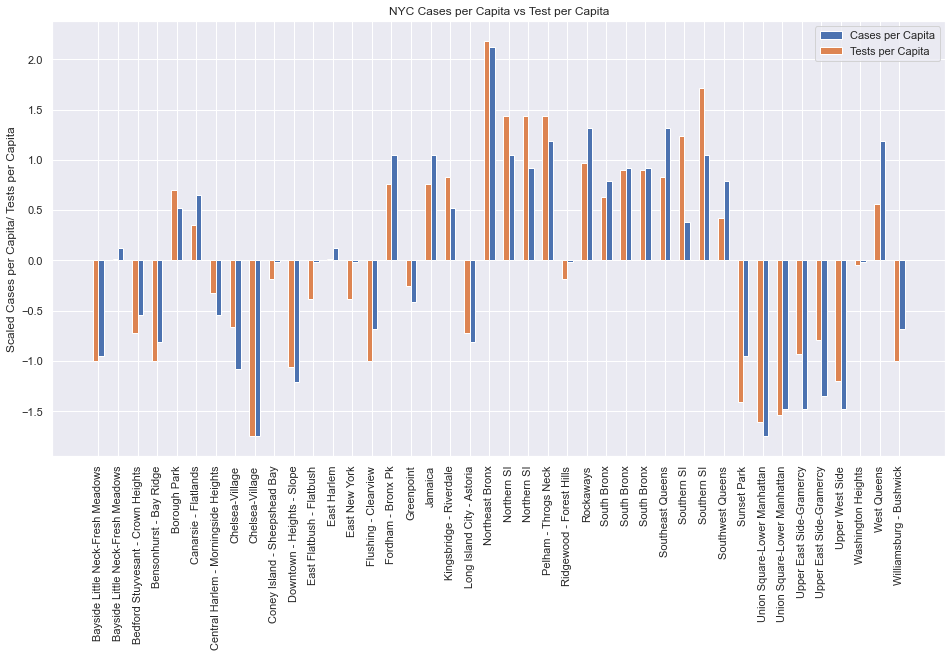

In [16]:
labels = case_per_neighborhood['uhf34_neigh'] #UHF34 Neighborhoods

x = np.arange(len(labels))  # the label locations
width = 0.275  # the width of the bars


scaled_positive_rate = scale(case_per_neighborhood['case_per_capita'])
scaled_test_per_capita = scale(case_per_neighborhood['test_per_capita'])

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x + width/2, scaled_positive_rate, width, label='Cases per Capita')
rects2 = ax.bar(x - width/2, scaled_test_per_capita, width, label='Tests per Capita')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scaled Cases per Capita/ Tests per Capita')
ax.set_title('NYC Cases per Capita vs Test per Capita')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)

ax.legend()

plt.show()

The graph shows that some neighborhoods are potentially undertested (e.g. West Queens, Rockaways) or overtested (e.g.  Knightbrigde, Borough Park).

In [17]:
obesity = pd.read_csv("data/overweight_obese.csv")

obesity.iloc[:,0] = obesity.copy().iloc[:,0].str.strip()

obesity.head()

,Geography,Indicator Name,Number,Percent
0,New York City,Overweight or Obese Adults,"3,692,000",57.4
1,Bronx,Overweight or Obese Adults,"720,000",69.3
2,Brooklyn,Overweight or Obese Adults,"1,132,000",58.2
3,Manhattan,Overweight or Obese Adults,"582,000",44.4
4,Queens,Overweight or Obese Adults,"1,037,000",58.2


In [18]:
case_per_neighborhood = merge_df(case_per_neighborhood, obesity[['Geography','Percent']],
                                                     left_on = 'uhf34_neigh',
                                                     right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "obesity_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3


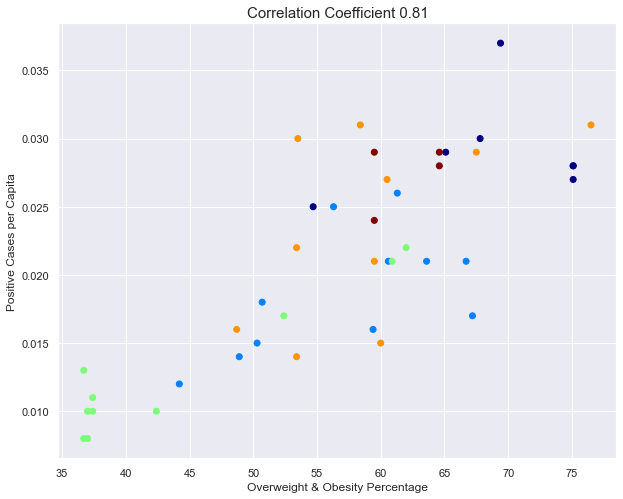

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['obesity_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['obesity_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Overweight & Obesity Percentage', fontsize=12)
ax.set_ylabel('Positive Cases per Capita', fontsize=12)

plt.show()

There is some strong positive correlation between obesity rate and postive COVID cases across neighborhoods.

In [20]:
excercise = pd.read_csv("data/exercise_2017.csv")

excercise.iloc[:,2] = excercise.copy().iloc[:,2].str.strip()

excercise.head()

,GeoTypeName,Borough,Geography,Geography ID,Number,Percent
0,Citywide,New York City,New York City,1,"4,893,000",74.5
1,Borough,Bronx,Bronx,1,"741,000",70.0
2,Borough,Brooklyn,Brooklyn,2,"1,421,000",71.8
3,Borough,Manhattan,Manhattan,3,"1,115,000",83.5
4,Borough,Queens,Queens,4,"1,355,000",74.0


In [21]:
case_per_neighborhood = merge_df(case_per_neighborhood, excercise[['Geography','Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "excercise_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,73.4
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,73.4
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,71.4
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,69.5
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,65.2


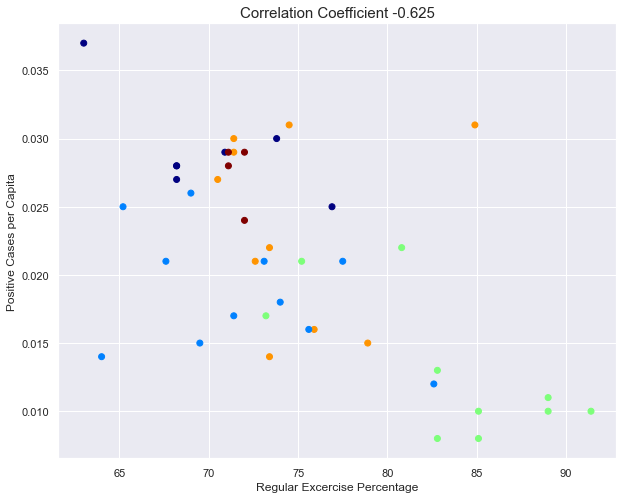

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['excercise_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['excercise_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Regular Excercise Percentage', fontsize=12)
ax.set_ylabel('Positive Cases per Capita', fontsize=12)

plt.show()

There is some medium-strong negative correlation between excercise rate and postive COVID cases across neighborhoods.

In [23]:
copd = pd.read_csv("data/copd_2016.csv")

copd.iloc[:,1] = copd.copy().iloc[:,1].str.strip()

copd.head()

,Borough,Geography,Indicator Name,"Age-Adjusted Rate (per 10,000 residents)","Estimated Annual Rate (per 10,000 residents)",Number
0,Bronx,Fordham - Bronx Pk,Chronic Obstructive Pulmonary Disease Hospita...,51.3,45.5,600
1,Bronx,Kingsbridge - Riverdale,Chronic Obstructive Pulmonary Disease Hospita...,37.5,33.8,546
2,Bronx,Northeast Bronx,Chronic Obstructive Pulmonary Disease Hospita...,54.2,52.1,707
3,Bronx,Pelham - Throgs Neck,Chronic Obstructive Pulmonary Disease Hospita...,56.9,53.5,467
4,Bronx,Hunts Point - Mott Haven,Chronic Obstructive Pulmonary Disease Hospita...,17.9,22.3,148


In [24]:
case_per_neighborhood = merge_df(case_per_neighborhood, copd[['Geography','Age-Adjusted Rate (per 10,000 residents)']], 
                                 left_on = 'uhf42_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Age-Adjusted Rate (per 10,000 residents)': "copd_rate"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,73.4,11.7
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,73.4,12.0
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,71.4,21.4
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,69.5,40.8
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,65.2,15.5


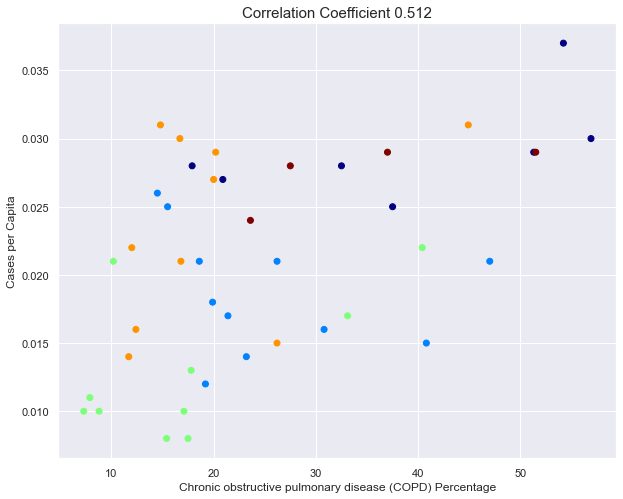

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['copd_rate'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['copd_rate'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Chronic obstructive pulmonary disease (COPD) Percentage', fontsize=12)
ax.set_ylabel('Cases per Capita', fontsize=12)

plt.show()

There is no strong correlation between COPD rate and positive case rate.

In [26]:
smoking = pd.read_csv("data/Cigarette Smoking among Adults.csv")

smoking.iloc[:,3] = smoking.copy().iloc[:,3].str.strip()

smoking.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,Number,Percent,Notes Number,Notes Percent
0,2017,Citywide,New York City,New York City,1,Cigarette Smoking among Adults,"886,000",13.5,NaN,NaN
1,2017,Borough,Bronx,Bronx,1,Cigarette Smoking among Adults,"145,000",13.7,NaN,NaN
2,2017,Borough,Brooklyn,Brooklyn,2,Cigarette Smoking among Adults,"270,000",13.7,NaN,NaN
3,2017,Borough,Manhattan,Manhattan,3,Cigarette Smoking among Adults,"161,000",12.0,NaN,NaN
4,2017,Borough,Queens,Queens,4,Cigarette Smoking among Adults,"224,000",12.4,NaN,NaN


In [27]:
case_per_neighborhood = merge_df(case_per_neighborhood, smoking[['Geography','Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "smoking_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,73.4,11.7,11.2
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,73.4,12.0,11.2
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,71.4,21.4,18.9
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,69.5,40.8,11.7
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,65.2,15.5,9.8


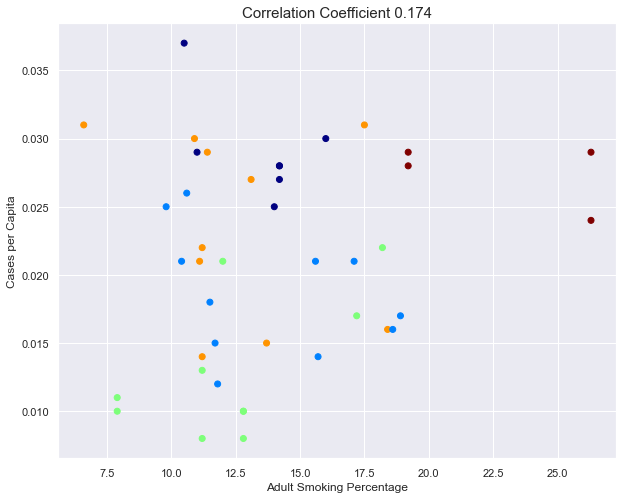

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['smoking_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['smoking_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Adult Smoking Percentage', fontsize=12)
ax.set_ylabel('Cases per Capita', fontsize=12)

plt.show()

There is no correlation at all between smoking and positive cases.

In [29]:
drinking = pd.read_csv("data/Adults Who Binge Drink.csv")

drinking.iloc[:,3] = drinking.copy().iloc[:,3].str.strip()

drinking.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,Number,Percent,Notes Number,Notes Percent
0,2017,Citywide,New York City,New York City,1,Adults Who Binge Drink,"1,126,000",17.4,NaN,NaN
1,2017,Borough,Bronx,Bronx,1,Adults Who Binge Drink,"145,000",14.0,NaN,NaN
2,2017,Borough,Brooklyn,Brooklyn,2,Adults Who Binge Drink,"307,000",15.7,NaN,NaN
3,2017,Borough,Manhattan,Manhattan,3,Adults Who Binge Drink,"340,000",25.6,NaN,NaN
4,2017,Borough,Queens,Queens,4,Adults Who Binge Drink,"271,000",15.1,NaN,NaN


In [30]:
case_per_neighborhood = merge_df(case_per_neighborhood, drinking[['Geography','Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "drinking_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,73.4,11.7,11.2,11.7
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,73.4,12.0,11.2,11.7
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,71.4,21.4,18.9,16.6
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,69.5,40.8,11.7,15.4
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,65.2,15.5,9.8,9.5


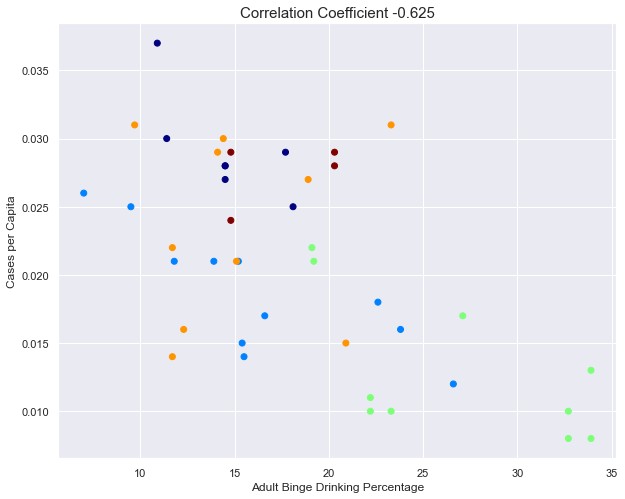

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['drinking_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['drinking_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Adult Binge Drinking Percentage', fontsize=12)
ax.set_ylabel('Cases per Capita', fontsize=12)

plt.show()

Semi-strong correlation between alcoholic drinking and positive cases.

In [32]:
asthma = pd.read_csv("data/Adults with Asthma in the Past 12 Months.csv")

asthma.iloc[:,3] = asthma.copy().iloc[:,3].str.strip()

asthma.fillna(asthma.mean(), inplace = True)

asthma.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,Age-Adjusted Percent,Number,Percent,Notes Age-Adjusted Percent,Notes Number,Notes Percent
0,2017,Citywide,New York City,New York City,1,Adults with Asthma in the Past 12 Months,4.3,"289,000",4.4,NaN,NaN,NaN
1,2017,Borough,Bronx,Bronx,1,Adults with Asthma in the Past 12 Months,6.8,"74,000",6.2,NaN,NaN,NaN
2,2017,Borough,Brooklyn,Brooklyn,2,Adults with Asthma in the Past 12 Months,3.7,"73,000",4.0,NaN,NaN,NaN
3,2017,Borough,Manhattan,Manhattan,3,Adults with Asthma in the Past 12 Months,4.6,"61,000",4.1,NaN,NaN,NaN
4,2017,Borough,Queens,Queens,4,Adults with Asthma in the Past 12 Months,3.9,"76,000",5.0,NaN,NaN,NaN


In [33]:
case_per_neighborhood = merge_df(case_per_neighborhood, asthma[['Geography','Age-Adjusted Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Age-Adjusted Percent': "asthma_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,asthma_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,73.4,11.7,11.2,11.7,1.9
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,73.4,12.0,11.2,11.7,1.9
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,71.4,21.4,18.9,16.6,7.5
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,69.5,40.8,11.7,15.4,2.2
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,65.2,15.5,9.8,9.5,2.2


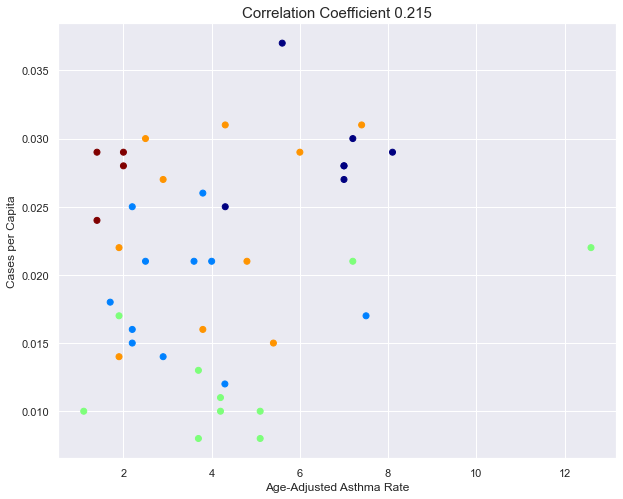

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['asthma_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['asthma_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Age-Adjusted Asthma Rate', fontsize=12)
ax.set_ylabel('Cases per Capita', fontsize=12)

plt.show()

We don't really see a strong correlation between asthma level among adults and positive COVID-19 cases.

In [35]:
heart_attacks = pd.read_csv("data/Heart Attack Hospitalizations.csv")

heart_attacks.iloc[:,3] = heart_attacks.copy().iloc[:,3].str.strip()

# heart_attacks.fillna(asthma.mean(), inplace = True)

heart_attacks['population_all'] = (heart_attacks['Number - Adults 35 to 64 Yrs Old'].str.replace(",","").astype(int)/(heart_attacks['Age-Adjusted Rate - Adults 35 to 64 Yrs Old (per 10,000 residents)']/100)
                                   + heart_attacks['Number - Adults 65 Yrs and Older'].str.replace(",","").astype(int)/(heart_attacks['Age-Adjusted Rate Adults - 65 Yrs and Older (per 10,000 residents)']/100))
 
heart_attacks['age_adjusted_rate_all'] = np.round((heart_attacks['Number - Adults 35 to 64 Yrs Old'].str.replace(",","").astype(int) 
                                           + heart_attacks['Number - Adults 65 Yrs and Older'].str.replace(",","").astype(int))
                                          / heart_attacks['population_all']*100, 1)


heart_attacks.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,"Age-Adjusted Rate - Adults 35 to 64 Yrs Old (per 10,000 residents)","Age-Adjusted Rate Adults - 65 Yrs and Older (per 10,000 residents)",Number - Adults 35 to 64 Yrs Old,Number - Adults 65 Yrs and Older,"Rate - Adults 35 to 64 Yrs Old (per 10,000 residents)","Rate - Adults 65 Yrs and Older (per 10,000 residents)",Notes Age-Adjusted Rate - Adults 35 to 64 Yrs Old,Notes Age-Adjusted Rate Adults - 65 Yrs and Older,Notes Number - Adults 35 to 64 Yrs Old,Notes Number - Adults 65 Yrs and Older,Notes Rate - Adults 35 to 64 Yrs Old,Notes Rate - Adults 65 Yrs and Older,population_all,age_adjusted_rate_all
0,2016,Borough,Bronx,Bronx,1,Heart Attack Hospitalizations,14.3,52.2,848,872,16.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,7600.568014,22.6
1,2016,Neighborhood (UHF 42),Bronx,Crotona-Tremont,105,Heart Attack Hospitalizations,15.8,59.1,136,104,17.5,54.8,NaN,NaN,NaN,NaN,NaN,NaN,1036.732421,23.1
2,2016,Neighborhood (UHF 42),Bronx,Fordham - Bronx Pk,103,Heart Attack Hospitalizations,12.8,50.5,129,123,14.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,1251.376856,20.1
3,2016,Neighborhood (UHF 42),Bronx,High Bridge - Morrisania,106,Heart Attack Hospitalizations,16.6,59.7,146,123,18.5,56.1,NaN,NaN,NaN,NaN,NaN,NaN,1085.548223,24.8
4,2016,Neighborhood (UHF 42),Bronx,Hunts Point - Mott Haven,107,Heart Attack Hospitalizations,19.8,79.4,105,112,21.6,76.6,NaN,NaN,NaN,NaN,NaN,NaN,671.360965,32.3


In [36]:
case_per_neighborhood = merge_df(case_per_neighborhood, heart_attacks[['Geography','age_adjusted_rate_all']], 
                                 left_on = 'uhf42_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'age_adjusted_rate_all': "heart_attack_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,asthma_percent,heart_attack_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,73.4,11.7,11.2,11.7,1.9,11.7
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,73.4,12.0,11.2,11.7,1.9,16.8
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,71.4,21.4,18.9,16.6,7.5,26.9
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,69.5,40.8,11.7,15.4,2.2,20.3
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,65.2,15.5,9.8,9.5,2.2,25.1


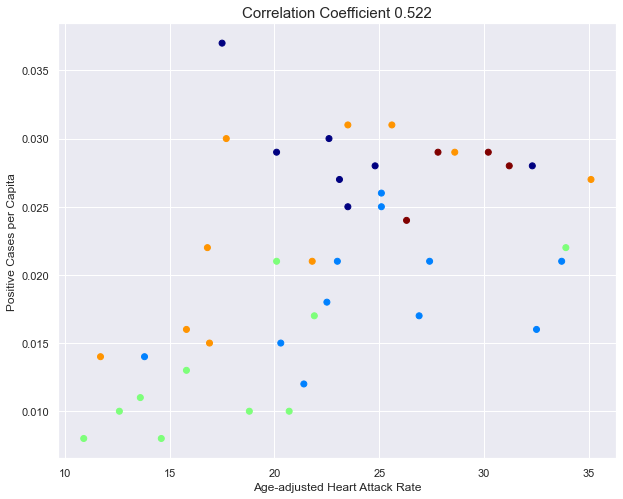

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['heart_attack_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['heart_attack_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Age-adjusted Heart Attack Rate', fontsize=12)
ax.set_ylabel('Positive Cases per Capita', fontsize=12)

plt.show()

### Dimention Reduction - PCA

In [39]:
pca = PCA(n_components=3)

In [40]:
neighborhoods = case_per_neighborhood.iloc[:,0:3]
metrics = case_per_neighborhood.iloc[:,7:]

In [81]:
pca_transformed = pca.fit_transform(scale(metrics))

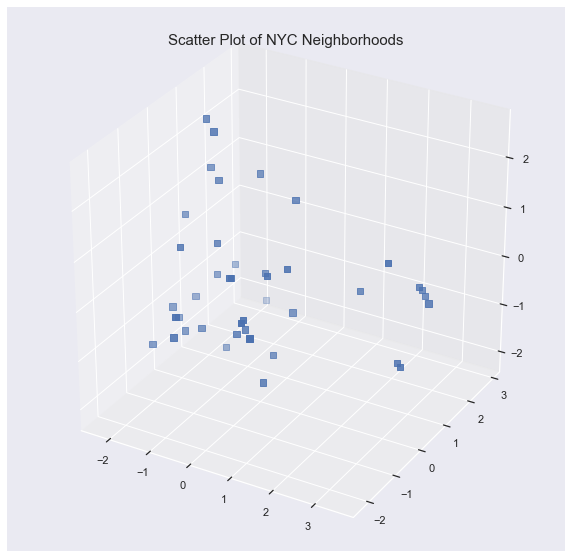

In [82]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(pca_transformed[:,0])
y = np.array(pca_transformed[:,1])
z = np.array(pca_transformed[:,2])

ax.set_title('Scatter Plot of NYC Neighborhoods', fontsize=15)
ax.scatter(x,y,z, marker="s",  s=40, cmap="RdBu")

plt.show();

### Dimention Reduction - t-Distributed Stochastic Neighbouring

In [83]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(scale(metrics))

[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 5.553326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.136261
[t-SNE] KL divergence after 300 iterations: 2.381648


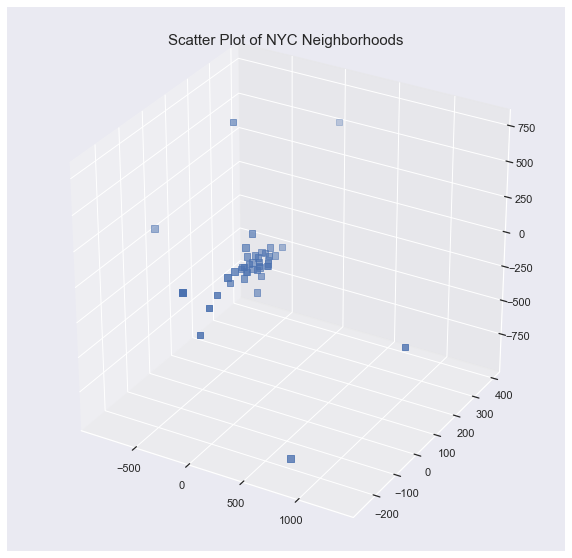

In [84]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(tsne_results[:,0])
y = np.array(tsne_results[:,1])
z = np.array(tsne_results[:,2])

ax.set_title('Scatter Plot of NYC Neighborhoods', fontsize=15)
ax.scatter(x,y,z, marker="s",  s=40, cmap="RdBu")

plt.show();

In [98]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(scale(metrics))
cluster_kmeans = kmeans.predict(scale(metrics))

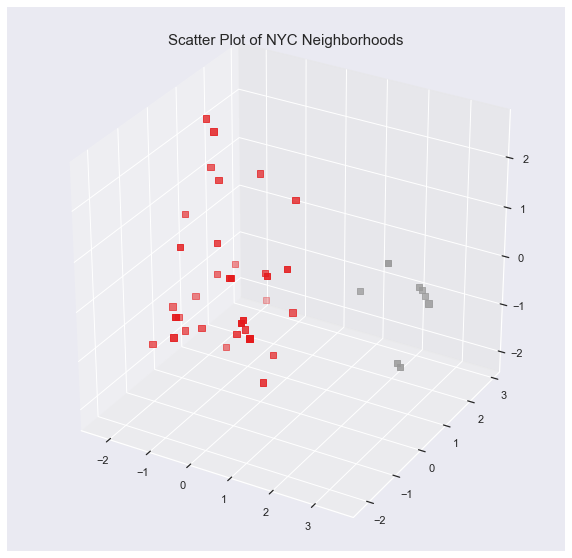

In [99]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(pca_transformed[:,0])
y = np.array(pca_transformed[:,1])
z = np.array(pca_transformed[:,2])

ax.set_title('Scatter Plot of NYC Neighborhoods', fontsize=15)
ax.scatter(x,y,z, c=cluster_kmeans, marker="s", s=40, cmap = 'Set1')

plt.show();

In [100]:
case_per_neighborhood['cluster'] = cluster_kmeans

In [101]:
cluser_0 = case_per_neighborhood[case_per_neighborhood['cluster'] == 0]

cluser_0.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,asthma_percent,heart_attack_percent,cluster
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,73.4,11.7,11.2,11.7,1.9,11.7,0
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,73.4,12.0,11.2,11.7,1.9,16.8,0
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,71.4,21.4,18.9,16.6,7.5,26.9,0
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,69.5,40.8,11.7,15.4,2.2,20.3,0
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,65.2,15.5,9.8,9.5,2.2,25.1,0


In [102]:
cluser_1 = case_per_neighborhood[case_per_neighborhood['cluster'] == 1]

cluser_1.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,asthma_percent,heart_attack_percent,cluster
7,Manhattan,Chelsea-Village,Chelsea-Clinton,143506,29.83,0.013,0.045,36.7,82.8,17.8,11.2,33.9,3.7,15.8,1
8,Manhattan,Chelsea-Village,Greenwich Village - Soho,83664,27.32,0.008,0.029,36.7,82.8,15.4,11.2,33.9,3.7,10.9,1
10,Brooklyn,Downtown - Heights - Slope,Downtown-Heights -Slope,227057,30.64,0.012,0.039,44.2,82.6,19.2,11.8,26.6,4.3,21.4,1
34,Manhattan,Union Square-Lower Manhattan,Lower Manhattan,53215,25.78,0.008,0.031,37.0,85.1,17.5,12.8,32.7,5.1,14.6,1
35,Manhattan,Union Square-Lower Manhattan,Union Square - Lower East Side,199170,32.34,0.010,0.032,37.0,85.1,8.8,12.8,32.7,5.1,18.8,1


In [104]:
cluster_0_means = np.mean(cluser_0)

cluster_0_means

population              203316.852941
positive_rate               40.123529
case_per_capita              0.023647
test_per_capita              0.058853
obesity_percent             61.241176
excercise_percent           72.305882
copd_rate                   27.885294
smoking_percent             14.632353
drinking_percent            15.900000
asthma_percent               4.359288
heart_attack_percent        24.091176
cluster                      0.000000
dtype: float64

In [105]:
cluster_1_means = np.mean(cluser_1)

cluster_1_means

population              160446.750000
positive_rate               27.915000
case_per_capita              0.010250
test_per_capita              0.037125
obesity_percent             38.600000
excercise_percent           85.975000
copd_rate                   13.875000
smoking_percent             11.050000
drinking_percent            28.437500
asthma_percent               3.925000
heart_attack_percent        16.050000
cluster                      1.000000
dtype: float64

In [107]:
cluster_means = pd.concat([cluster_0_means,cluster_1_means], axis = 1)

cluster_means.rename(columns = {0: 'Cluster 0', 1: 'Cluster 1'}, inplace = True)

cluster_means

,Cluster 0,Cluster 1
population,203316.852941,160446.750000
positive_rate,40.123529,27.915000
case_per_capita,0.023647,0.010250
test_per_capita,0.058853,0.037125
obesity_percent,61.241176,38.600000
excercise_percent,72.305882,85.975000
copd_rate,27.885294,13.875000
smoking_percent,14.632353,11.050000
drinking_percent,15.900000,28.437500
asthma_percent,4.359288,3.925000


In [108]:
cluser_0.groupby('borough')['uhf42_neigh'].count()

borough
Bronx             7
Brooklyn         10
Manhattan         3
Queens           10
Staten Island     4
Name: uhf42_neigh, dtype: int64

In [109]:
cluser_1.groupby('borough')['uhf42_neigh'].count()

borough
Brooklyn     1
Manhattan    7
Name: uhf42_neigh, dtype: int64

Cluser 0 seems to be the one with higher risk, associated with more case per capita and many other features are not in its favors. All Queens, Bronx, & Staten Island neighborhoods belong to Cluster 0 with some from Manhattan. Brooklyn only has 1 in Cluster 1.

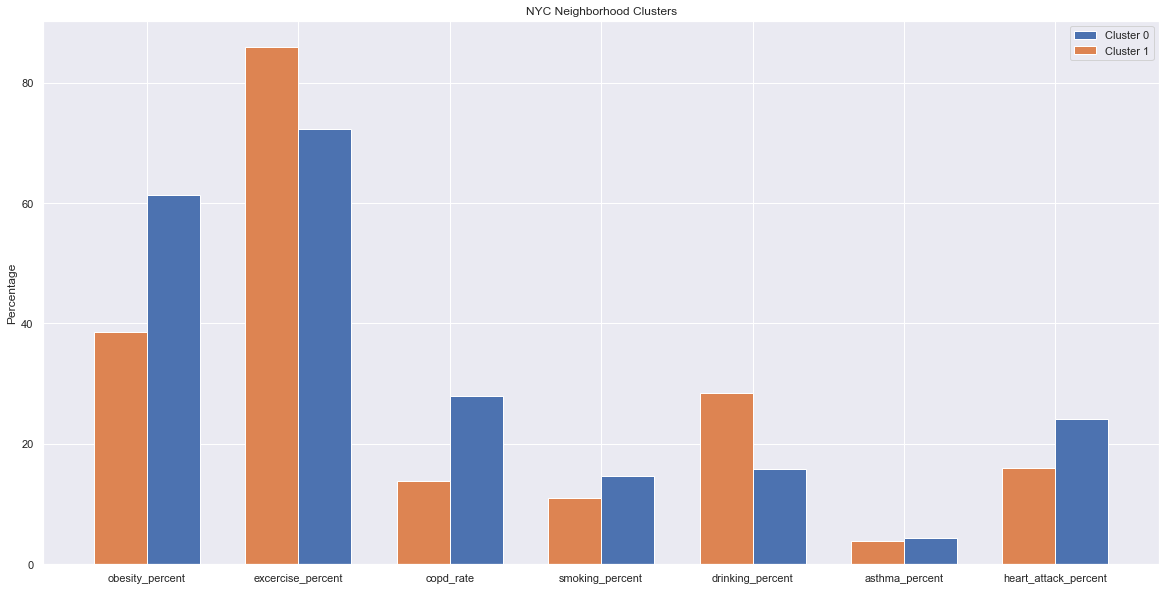

In [110]:
labels = case_per_neighborhood.columns[7:-1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x + width/2, cluster_means.iloc[4:-1,0], width, label='Cluster 0')
rects2 = ax.bar(x - width/2, cluster_means.iloc[4:-1,1], width, label='Cluster 1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('NYC Neighborhood Clusters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [111]:
case_per_MODZCTA = test_by_zip.merge(case_per_neighborhood, left_on = 'uhf42_neigh', right_on = 'uhf42_neigh')

case_per_MODZCTA.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh_x,uhf42_neigh,borough,uhf34_neigh_y,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,asthma_percent,heart_attack_percent,cluster
0,10001,321,1130,28.41,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,82.8,17.8,11.2,33.9,3.7,15.8,1
1,10011,478,1606,29.76,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,82.8,17.8,11.2,33.9,3.7,15.8,1
2,10018,196,626,31.31,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,82.8,17.8,11.2,33.9,3.7,15.8,1
3,10019,547,1832,29.86,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,82.8,17.8,11.2,33.9,3.7,15.8,1
4,10036,377,1240,30.40,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,82.8,17.8,11.2,33.9,3.7,15.8,1


In [112]:
nyc_map = gpd.read_file('data/Geography-resources/MODZCTA_2010_WGS1984.geo.json')

nyc_map = nyc_map.merge(case_per_MODZCTA, left_on = 'MODZCTA', right_on = 'MODZCTA')

In [113]:
nyc_map['coords'] = nyc_map['geometry'].apply(lambda x: x.centroid.coords[:])
nyc_map['coords'] = [coords[0] for coords in nyc_map['coords']]

In [114]:
#Tranforming Pandas DF back to GeoDF

crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(nyc_map, crs=crs, geometry=nyc_map['geometry'])

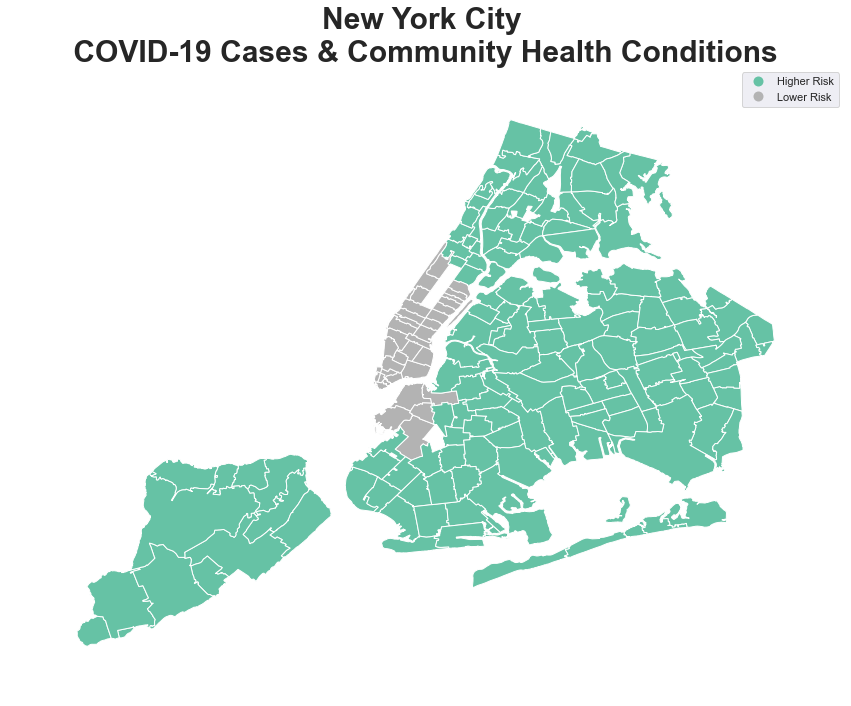

In [120]:
import mapclassify as mc

scheme = mc.Quantiles(gdf['cluster'], k=2)

geoplot.choropleth(gdf, hue='cluster',scheme = scheme, cmap='Set2',legend=True,legend_values = [0,1],
                        legend_labels = ['Higher Risk', 'Lower Risk'],
                        figsize=(15, 15))

plt.title("New York City \n COVID-19 Cases & Community Health Conditions ",fontdict = {'weight': 'bold', 'size': 30})

plt.show()

In [72]:
case_per_neighborhood.to_csv('data/case_per_neighborhood.csv', index=False, encoding='utf-8')